In [1]:
# import libraries and dependencies
import pandas as pd
import numpy as np
import yfinance as yf
from pandas_datareader import data as pdr
import hvplot.pandas
from stockstats import StockDataFrame

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
# set ticker
ticker = 'TSLA'

# set timefrom for data
start = '2016-01-01'
end = '2021-04-30'

# pull historical stock data
yf.pdr_override()
df_ETH_data = pdr.get_data_yahoo(ticker, start = start, end = end)
df_ETH_data.reset_index(inplace=True)
df_ETH_data.rename(columns = {'Adj Close': 'Adj. Close'}, inplace = True )
df_ETH_data['daily_return'] = df_ETH_data['Close'].pct_change()
date_list = df_ETH_data['Date'].to_list()

df_ETH_data.head()

[*********************100%***********************]  1 of 1 completed


Date       Open       High        Low      Close  Adj. Close  \
0 2016-01-04  46.144001  46.276001  43.799999  44.681999   44.681999   
1 2016-01-05  45.271999  45.377998  44.000000  44.686001   44.686001   
2 2016-01-06  44.000000  44.009998  43.195999  43.807999   43.807999   
3 2016-01-07  42.838001  43.688000  42.734001  43.130001   43.130001   
4 2016-01-08  43.571999  44.088001  42.153999  42.200001   42.200001   

     Volume  daily_return  
0  34135500           NaN  
1  15934000      0.000090  
2  18895500     -0.019648  
3  17771500     -0.015477  
4  18140500     -0.021563

In [3]:
ETH_rsi = StockDataFrame.retype(df_ETH_data)
ETH_rsi['rsi_14']

date
2016-01-04           NaN
2016-01-05    100.000000
2016-01-06      0.421426
2016-01-07      0.230527
2016-01-08      0.138110
                 ...    
2021-04-23     54.840407
2021-04-26     56.332412
2021-04-27     49.619627
2021-04-28     47.726912
2021-04-29     44.641016
Name: rsi_14, Length: 1340, dtype: float64

In [4]:
# Initialize the new `Signal` column
ETH_rsi['rsi_signal'] = 0.0
ETH_rsi.replace([np.inf, -np.inf], np.nan, inplace=True)
ETH_rsi.head()
ETH_rsi = ETH_rsi.dropna()

In [5]:
#Fill our newly created position column - set to sell (-1) when the price hits the upper band, and set to buy (1) when it hits the lower band
ETH_rsi['holding'] = False
      
# Print the DataFrame
ETH_rsi.head()

open       high        low      close  adj. close    volume  \
date                                                                           
2016-01-06  44.000000  44.009998  43.195999  43.807999   43.807999  18895500   
2016-01-07  42.838001  43.688000  42.734001  43.130001   43.130001  17771500   
2016-01-08  43.571999  44.088001  42.153999  42.200001   42.200001  18140500   
2016-01-11  42.801998  42.889999  40.599998  41.570000   41.570000  20457000   
2016-01-12  42.320000  42.748001  41.062000  41.993999   41.993999  15459500   

            daily_return  close_-1_s  close_-1_d     rs_14     rsi_14  \
date                                                                    
2016-01-06     -0.019648   44.686001   -0.878002  0.004232   0.421426   
2016-01-07     -0.015477   43.807999   -0.677998  0.002311   0.230527   
2016-01-08     -0.021563   43.130001   -0.930000  0.001383   0.138110   
2016-01-11     -0.014929   42.200001   -0.630001  0.001070   0.106858   
2016-01-12      0.010200   41.570000    0.424000  0.165252  14.181642   

            rsi_signal  holding  
date                             
2016-01-06         0.0    False  
2016-01-07         0.0    False  
2016-01-08         0.0    False  
2016-01-11         0.0    False  
2016-01-12         0.0    False

In [6]:
# Initialize the new 'Signal' column
# ETH_rsi['rsi_signal'] = 0.0
ETH_rsi['open_position'] = 0.0
# Fill our newly created position column - set to sell (-1) when rsi_14 > 70 and set to buy (1) when rsi_14 < 30.
position = 'close'

for row in range(len(ETH_rsi)):
    
    if position == 'close':
        #ETH_rsi['open_position'].iloc[row] = 0.0
        if (ETH_rsi['rsi_14'].iloc[row] < 30 and (ETH_rsi['rsi_14'].iloc[row-1] > 30)):
            ETH_rsi['rsi_signal'].iloc[row] = 1
            ETH_rsi['open_position'].iloc[row] =1
            position = 'open'
        else: #(ETH_rsi['rsi_14'].iloc[row] > 70 and (ETH_rsi['rsi_14'].iloc[row-1] < 70))
            ETH_rsi['rsi_signal'].iloc[row] = 0.0
            ETH_rsi['open_position'].iloc[row] = ETH_rsi['open_position'].iloc[row-1]
            #position = 'close'
    
    else: #position == 'open':
        #ETH_rsi['open_position'].iloc[row] = 1
        #if (ETH_rsi['rsi_14'].iloc[row] < 30 and (ETH_rsi['rsi_14'].iloc[row-1] > 30)):
            #ETH_rsi['rsi_signal'].iloc[row] = 0.0
            #position = 'open'
        if (ETH_rsi['rsi_14'].iloc[row] > 70 and (ETH_rsi['rsi_14'].iloc[row-1] < 70)):
            ETH_rsi['rsi_signal'].iloc[row] = -1
            ETH_rsi['open_position'].iloc[row] = 0.0
            position = 'close'
        else: 
            ETH_rsi['rsi_signal'].iloc[row] = 0.0
            ETH_rsi['open_position'].iloc[row] = ETH_rsi['open_position'].iloc[row-1]
            
ETH_rsi.tail()

open        high         low       close  adj. close  \
date                                                                     
2021-04-23  719.799988  737.359985  715.460022  729.400024  729.400024   
2021-04-26  741.000000  749.299988  732.609985  738.200012  738.200012   
2021-04-27  717.960022  724.000000  703.349976  704.739990  704.739990   
2021-04-28  696.409973  708.500000  693.599976  694.400024  694.400024   
2021-04-29  699.510010  702.250000  668.500000  677.000000  677.000000   

              volume  daily_return  close_-1_s  close_-1_d     rs_14  \
date                                                                   
2021-04-23  28370000      0.013492  719.690002    9.710022  1.214369   
2021-04-26  31038500      0.012065  729.400024    8.799988  1.290028   
2021-04-27  29437000     -0.045326  738.200012  -33.460022  0.984900   
2021-04-28  22271000     -0.014672  704.739990  -10.339966  0.913030   
2021-04-29  28845400     -0.025058  694.400024  -17.400024  0.806392   

               rsi_14  rsi_signal  holding  open_position  
date                                                       
2021-04-23  54.840407         0.0    False            1.0  
2021-04-26  56.332412         0.0    False            1.0  
2021-04-27  49.619627         0.0    False            1.0  
2021-04-28  47.726912         0.0    False            1.0  
2021-04-29  44.641016         0.0    False            1.0

In [7]:
# Visualize exit position relative to close price
exit = ETH_rsi[ETH_rsi['rsi_signal'] == -1.0]['close'].hvplot.scatter(
    color='red',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400)

# Visualize entry position relative to close price
entry = ETH_rsi[ETH_rsi['rsi_signal'] == 1.0]['close'].hvplot.scatter(
    color='green',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400)

# Visualize close price for the investment
security_close = ETH_rsi[['close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400)

# Visualize moving averages
moving_avgs = ETH_rsi[['rsi_14']].hvplot(
    ylabel='Price in $',
    width=1000,
    height=400)

# Overlay plots
ETH_rsi_plot = security_close * entry * exit
ETH_rsi_plot.opts(xaxis=None)

:Overlay
   .Curve.I          :Curve   [date]   (close)
   .Scatter.Close.I  :Scatter   [date]   (close)
   .Scatter.Close.II :Scatter   [date]   (close)

In [8]:
# Set initial capital
initial_capital = float(10000000)

# Set the share size
share_size = float(1000)

# Take a 1000 share position RSI
ETH_rsi["Trade"] = share_size * ETH_rsi["rsi_signal"] 

# Find the points in time where a 1000 share position is bought or sold
ETH_rsi["Position"] = ETH_rsi["open_position"] * share_size

# Multiply share price by entry/exit positions and get the cumulatively sum
ETH_rsi["Portfolio Holdings"] = ETH_rsi["close"] * ETH_rsi["Position"]

# Subtract the initial capital by the portfolio holdings to get the amount of liquid cash in the portfolio
ETH_rsi["Portfolio Cash"] = (
    initial_capital - (ETH_rsi["Trade"] * ETH_rsi['close']).cumsum()
)

# Get the total portfolio value by adding the cash amount by the portfolio holdings (or investments)
ETH_rsi["Portfolio Total"] = (
    ETH_rsi["Portfolio Cash"] + ETH_rsi["Portfolio Holdings"]
)

# Calculate the portfolio daily returns
ETH_rsi["Portfolio Daily Returns"] = ETH_rsi["Portfolio Total"].pct_change()

# Calculate the cumulative returns
ETH_rsi["Portfolio Cumulative Returns"] = ( 1 + ETH_rsi["Portfolio Daily Returns"]).cumprod() - 1

# Print the DataFrame
ETH_rsi.tail()

open        high         low       close  adj. close  \
date                                                                     
2021-04-23  719.799988  737.359985  715.460022  729.400024  729.400024   
2021-04-26  741.000000  749.299988  732.609985  738.200012  738.200012   
2021-04-27  717.960022  724.000000  703.349976  704.739990  704.739990   
2021-04-28  696.409973  708.500000  693.599976  694.400024  694.400024   
2021-04-29  699.510010  702.250000  668.500000  677.000000  677.000000   

              volume  daily_return  close_-1_s  close_-1_d     rs_14  ...  \
date                                                                  ...   
2021-04-23  28370000      0.013492  719.690002    9.710022  1.214369  ...   
2021-04-26  31038500      0.012065  729.400024    8.799988  1.290028  ...   
2021-04-27  29437000     -0.045326  738.200012  -33.460022  0.984900  ...   
2021-04-28  22271000     -0.014672  704.739990  -10.339966  0.913030  ...   
2021-04-29  28845400     -0.025058  694.400024  -17.400024  0.806392  ...   

            rsi_signal  holding  open_position  Trade  Position  \
date                                                              
2021-04-23         0.0    False            1.0    0.0    1000.0   
2021-04-26         0.0    False            1.0    0.0    1000.0   
2021-04-27         0.0    False            1.0    0.0    1000.0   
2021-04-28         0.0    False            1.0    0.0    1000.0   
2021-04-29         0.0    False            1.0    0.0    1000.0   

            Portfolio Holdings  Portfolio Cash  Portfolio Total  \
date                                                              
2021-04-23       729400.024414    9.510846e+06     1.024025e+07   
2021-04-26       738200.012207    9.510846e+06     1.024905e+07   
2021-04-27       704739.990234    9.510846e+06     1.021559e+07   
2021-04-28       694400.024414    9.510846e+06     1.020525e+07   
2021-04-29       677000.000000    9.510846e+06     1.018785e+07   

            Portfolio Daily Returns  Portfolio Cumulative Returns  
date                                                               
2021-04-23                 0.000949                      0.024025  
2021-04-26                 0.000859                      0.024905  
2021-04-27                -0.003265                      0.021559  
2021-04-28                -0.001012                      0.020525  
2021-04-29                -0.001705                      0.018785  

[5 rows x 21 columns]

In [9]:
# Prepare DataFrame for metrics
metrics = [
    'Annual Return',
    'Cumulative Returns',
    'Annual Volatility',
    'Sharpe Ratio',
    'Sortino Ratio']

columns = ['Backtest']

# Initialize the DataFrame with index set to evaluation metrics and column as `Backtest` (just like PyFolio)
ETH_portfolio_evaluation_df = pd.DataFrame(index=metrics, columns=columns)
ETH_portfolio_evaluation_df

Backtest
Annual Return           NaN
Cumulative Returns      NaN
Annual Volatility       NaN
Sharpe Ratio            NaN
Sortino Ratio           NaN

In [10]:
# Calculate cumulative return
ETH_portfolio_evaluation_df.loc['Cumulative Returns'] = ETH_rsi['Portfolio Cumulative Returns'][-1]

In [11]:
# Calculate annualized return
ETH_portfolio_evaluation_df.loc['Annual Return'] = (
    ETH_rsi['Portfolio Daily Returns'].mean() * 252
)


In [12]:
# Calculate annual volatility
ETH_portfolio_evaluation_df.loc['Annual Volatility'] = (
    ETH_rsi['Portfolio Daily Returns'].std() * np.sqrt(252)
)


In [13]:
# Calculate Sharpe Ratio
ETH_portfolio_evaluation_df.loc['Sharpe Ratio'] = (
    ETH_rsi['Portfolio Daily Returns'].mean() * 252) / (
    ETH_rsi['Portfolio Daily Returns'].std() * np.sqrt(252)
)

In [14]:
# Calculate Downside Return
sortino_ratio_df = ETH_rsi[['Portfolio Daily Returns']]
sortino_ratio_df.loc[:,'Downside Returns'] = 0
sortino_ratio_df.head()

Portfolio Daily Returns  Downside Returns
date                                                 
2016-01-06                      NaN                 0
2016-01-07                -0.000068                 0
2016-01-08                -0.000093                 0
2016-01-11                -0.000063                 0
2016-01-12                 0.000042                 0

In [15]:
target = 0
mask = sortino_ratio_df['Portfolio Daily Returns'] < target
sortino_ratio_df.loc[mask, 'Downside Returns'] = sortino_ratio_df['Portfolio Daily Returns']**2

In [16]:
# Calculate Sortino Ratio
down_stdev = np.sqrt(sortino_ratio_df['Downside Returns'].mean()) * np.sqrt(252)
expected_return = sortino_ratio_df['Portfolio Daily Returns'].mean() * 252
sortino_ratio = expected_return/down_stdev

ETH_portfolio_evaluation_df.loc['Sortino Ratio'] = sortino_ratio
ETH_portfolio_evaluation_df.head()

Backtest
Annual Return       0.003541
Cumulative Returns  0.018785
Annual Volatility   0.008227
Sharpe Ratio        0.430462
Sortino Ratio        0.75777

In [17]:
# Initialize trade evaluation DataFrame with columns
ETH_trade_evaluation_df = pd.DataFrame(
    columns=[
        'Stock', 
        'Entry Date', 
        'Exit Date', 
        'Shares', 
        'Entry Share Price', 
        'Exit Share Price', 
        'Entry Portfolio Holding', 
        'Exit Portfolio Holding', 
        'Profit/Loss']
)

ETH_trade_evaluation_df

Empty DataFrame
Columns: [Stock, Entry Date, Exit Date, Shares, Entry Share Price, Exit Share Price, Entry Portfolio Holding, Exit Portfolio Holding, Profit/Loss]
Index: []

In [18]:

# Initialize iterative variables
entry_date = ''
exit_date = ''
entry_portfolio_holding = 0
exit_portfolio_holding = 0
share_size = 0
entry_share_price = 0
exit_share_price = 0

# Loop through signal DataFrame
# If `Entry/Exit` is 1, set entry trade metrics
# Else if `Entry/Exit` is -1, set exit trade metrics and calculate profit,
# Then append the record to the trade evaluation DataFrame
for index, row in ETH_rsi.iterrows():
    if row['rsi_signal'] == 1:
        entry_date = index
        entry_portfolio_holding = abs(row['Portfolio Holdings'])
        share_size = row['Trade']
        entry_share_price = row['close']

    elif row['rsi_signal'] == -1:
        exit_date = index
        exit_portfolio_holding = abs(row['close'] * row['Trade'])
        exit_share_price = row['close']
        profit_loss =  exit_portfolio_holding - entry_portfolio_holding
        ETH_trade_evaluation_df = ETH_trade_evaluation_df.append(
            {
                'Stock': ticker,
                'Entry Date': entry_date,
                'Exit Date': exit_date,
                'Shares': share_size,
                'Entry Share Price': entry_share_price,
                'Exit Share Price': exit_share_price,
                'Entry Portfolio Holding': entry_portfolio_holding,
                'Exit Portfolio Holding': exit_portfolio_holding,
                'Profit/Loss': profit_loss
            },
            ignore_index=True)

# Print the DataFrame
ETH_trade_evaluation_df

Stock Entry Date  Exit Date  Shares  Entry Share Price  Exit Share Price  \
0  TSLA 2016-01-06 2016-03-15  1000.0          43.807999         43.667999   
1  TSLA 2016-05-12 2016-12-23  1000.0          41.456001         42.667999   
2  TSLA 2017-11-02 2018-06-12  1000.0          59.852001         68.554001   
3  TSLA 2018-09-07 2019-07-15  1000.0          52.647999         50.700001   
4  TSLA 2020-03-16 2020-06-08  1000.0          89.014000        189.983994   

   Entry Portfolio Holding  Exit Portfolio Holding    Profit/Loss  
0             43807.998657            43667.999268    -139.999390  
1             41456.001282            42667.999268    1211.997986  
2             59852.001190            68554.000854    8701.999664  
3             52647.998810            50700.000763   -1947.998047  
4             89013.999939           189983.993530  100969.993591

## Create Hvplot Table of Portfolio Metrics

In [19]:
ETH_portfolio_evaluation_df.reset_index(inplace=True)
ETH_portfolio_evaluation_table = ETH_portfolio_evaluation_df.hvplot.table()
ETH_portfolio_evaluation_table

:Table   [index,Backtest]

## Create Hvplot Table of Trade Metrics

In [20]:
ETH_trade_evaluation_table = ETH_trade_evaluation_df.hvplot.table()
ETH_trade_evaluation_table

:Table   [Stock,Entry Date,Exit Date,Shares,Entry Share Price,Exit Share Price,Entry Portfolio Holding,Exit Portfolio Holding,Profit/Loss]

## Build a Dashboard with `hvplot`

In [21]:
# Assemble dashboard visualization

ETH_portfolio_evaluation_table + ETH_trade_evaluation_table

:Layout
   .Table.I  :Table   [index,Backtest]
   .Table.II :Table   [Stock,Entry Date,Exit Date,Shares,Entry Share Price,Exit Share Price,Entry Portfolio Holding,Exit Portfolio Holding,Profit/Loss]

## Construct Simple Moving Average of Closing Prices to get trading signal

In [22]:
#get ETH sma
ETH_sma = StockDataFrame.retype(df_ETH_data)
ETH_sma['open_50_sma']
ETH_sma['open_100_sma']

date
2016-01-04     46.144001
2016-01-05     45.708000
2016-01-06     45.138667
2016-01-07     44.563500
2016-01-08     44.365200
                 ...    
2021-04-23    719.270402
2021-04-26    720.658301
2021-04-27    721.862001
2021-04-28    723.261701
2021-04-29    724.356601
Name: open_100_sma, Length: 1340, dtype: float64

In [23]:
# Initialize the new `Signal` column
ETH_sma['sma_signal'] = 0.0


ETH_sma.tail()

open        high         low       close  adj. close  \
date                                                                     
2021-04-23  719.799988  737.359985  715.460022  729.400024  729.400024   
2021-04-26  741.000000  749.299988  732.609985  738.200012  738.200012   
2021-04-27  717.960022  724.000000  703.349976  704.739990  704.739990   
2021-04-28  696.409973  708.500000  693.599976  694.400024  694.400024   
2021-04-29  699.510010  702.250000  668.500000  677.000000  677.000000   

              volume  daily_return  close_-1_s  close_-1_d   closepm  \
date                                                                   
2021-04-23  28370000      0.013492  719.690002    9.710022  9.710022   
2021-04-26  31038500      0.012065  729.400024    8.799988  8.799988   
2021-04-27  29437000     -0.045326  738.200012  -33.460022  0.000000   
2021-04-28  22271000     -0.014672  704.739990  -10.339966  0.000000   
2021-04-29  28845400     -0.025058  694.400024  -17.400024  0.000000   

              closenm  closepm_14_smma  closenm_14_smma     rs_14     rsi_14  \
date                                                                           
2021-04-23   0.000000        10.864961         8.947002  1.214369  54.840407   
2021-04-26   0.000000        10.717463         8.307930  1.290028  56.332412   
2021-04-27  33.460022         9.951930        10.104508  0.984900  49.619627   
2021-04-28  10.339966         9.241078        10.121327  0.913030  47.726912   
2021-04-29  17.400024         8.581001        10.641234  0.806392  44.641016   

            open_50_sma  open_100_sma  sma_signal  
date                                               
2021-04-23   698.219001    719.270402         0.0  
2021-04-26   696.790201    720.658301         0.0  
2021-04-27   695.124202    721.862001         0.0  
2021-04-28   692.692401    723.261701         0.0  
2021-04-29   691.100801    724.356601         0.0

In [24]:
# Generate the trading signal 0 or 1
ETH_sma['sma_signal'] = np.where(ETH_sma['open_50_sma']> ETH_sma['open_100_sma'], 1.0, 0.0)

# Calculate the points in time at which a position should be taken, 1 or -1
ETH_sma['Entry/Exit'] = ETH_sma['sma_signal'].diff()

# Print the DataFrame
ETH_sma.tail(10)

# drop useless columns
ETH_sma = ETH_sma.drop(columns = ['open','high','low','adj. close','volume', 'daily_return',
                                 'close_-1_s','close_-1_d','closepm','closenm','closepm_14_smma',	
                                  'closenm_14_smma','rs_14','rsi_14'])
ETH_sma.tail()

close  open_50_sma  open_100_sma  sma_signal  Entry/Exit
date                                                                     
2021-04-23  729.400024   698.219001    719.270402         0.0         0.0
2021-04-26  738.200012   696.790201    720.658301         0.0         0.0
2021-04-27  704.739990   695.124202    721.862001         0.0         0.0
2021-04-28  694.400024   692.692401    723.261701         0.0         0.0
2021-04-29  677.000000   691.100801    724.356601         0.0         0.0

## Plot Entry and Exit Points of Dual Moving Average Crossover Trading Strategy

In [25]:
# Visualize exit position relative to close price
exit = ETH_sma[ETH_sma['Entry/Exit'] == -1.0]['close'].hvplot.scatter(
    color='red',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize entry position relative to close price
entry = ETH_sma[ETH_sma['Entry/Exit'] == 1.0]['close'].hvplot.scatter(
    color='green',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize close price for the investment
security_close = ETH_sma[['close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize moving averages
moving_avgs = ETH_sma[['open_50_sma', 'open_100_sma']].hvplot(
    ylabel='Price in $',
    width=1000,
    height=400
)

# Overlay plots
entry_exit_plot = security_close * moving_avgs * entry * exit
entry_exit_plot.opts(xaxis=None)

:Overlay
   .Curve.I          :Curve   [date]   (close)
   .NdOverlay.I      :NdOverlay   [Variable]
      :Curve   [date]   (value)
   .Scatter.Close.I  :Scatter   [date]   (close)
   .Scatter.Close.II :Scatter   [date]   (close)

## Backtest the Trading Strategy

In [26]:
# Set initial capital
initial_capital = float(100000)

# Set the share size
share_size = 1000

# Take a 1000 share position where the dual moving average crossover is 1 (SMA50 is greater than SMA100)
ETH_sma['Position'] = share_size * ETH_sma['sma_signal']

# Find the points in time where a 500 share position is bought or sold
ETH_sma['Entry/Exit Position'] = ETH_sma['Position'].diff()

# Multiply share price by entry/exit positions and get the cumulatively sum
ETH_sma['Portfolio Holdings'] = ETH_sma['close'] * ETH_sma['Entry/Exit Position'].cumsum()

# Subtract the initial capital by the portfolio holdings to get the amount of liquid cash in the portfolio
ETH_sma['Portfolio Cash'] = initial_capital - (ETH_sma['close'] * ETH_sma['Entry/Exit Position']).cumsum()

# Get the total portfolio value by adding the cash amount by the portfolio holdings (or investments)
ETH_sma['Portfolio Total'] = ETH_sma['Portfolio Cash'] + ETH_sma['Portfolio Holdings']

# Calculate the portfolio daily returns
ETH_sma['Portfolio Daily Returns'] = ETH_sma['Portfolio Total'].pct_change()

# Calculate the cumulative returns
ETH_sma['Portfolio Cumulative Returns'] = (1 + ETH_sma['Portfolio Daily Returns']).cumprod() - 1

# Print the DataFrame
ETH_sma.tail()

close  open_50_sma  open_100_sma  sma_signal  Entry/Exit  \
date                                                                        
2021-04-23  729.400024   698.219001    719.270402         0.0         0.0   
2021-04-26  738.200012   696.790201    720.658301         0.0         0.0   
2021-04-27  704.739990   695.124202    721.862001         0.0         0.0   
2021-04-28  694.400024   692.692401    723.261701         0.0         0.0   
2021-04-29  677.000000   691.100801    724.356601         0.0         0.0   

            Position  Entry/Exit Position  Portfolio Holdings  Portfolio Cash  \
date                                                                            
2021-04-23       0.0                  0.0                 0.0   756608.005524   
2021-04-26       0.0                  0.0                 0.0   756608.005524   
2021-04-27       0.0                  0.0                 0.0   756608.005524   
2021-04-28       0.0                  0.0                 0.0   756608.005524   
2021-04-29       0.0                  0.0                 0.0   756608.005524   

            Portfolio Total  Portfolio Daily Returns  \
date                                                   
2021-04-23    756608.005524                      0.0   
2021-04-26    756608.005524                      0.0   
2021-04-27    756608.005524                      0.0   
2021-04-28    756608.005524                      0.0   
2021-04-29    756608.005524                      0.0   

            Portfolio Cumulative Returns  
date                                      
2021-04-23                       6.56608  
2021-04-26                       6.56608  
2021-04-27                       6.56608  
2021-04-28                       6.56608  
2021-04-29                       6.56608

In [27]:
# Visualize exit position relative to total portfolio value
exit = ETH_sma[ETH_sma['Entry/Exit'] == -1.0]['Portfolio Total'].hvplot.scatter(
    color='red',
    legend=False,
    ylabel='Total Portfolio Value',
    width=1000,
    height=400
)

# Visualize entry position relative to total portfolio value
entry = ETH_sma[ETH_sma['Entry/Exit'] == 1.0]['Portfolio Total'].hvplot.scatter(
    color='green',
    legend=False,
    ylabel='Total Portfolio Value',
    width=1000,
    height=400
)

# Visualize total portoflio value for the investment
total_portfolio_value = ETH_sma[['Portfolio Total']].hvplot(
    line_color='lightgray',
    ylabel='Total Portfolio Value',
    width=1000,
    height=400
)

# Overlay plots
ETH_sma_portfolio_entry_exit_plot = total_portfolio_value * entry * exit
ETH_sma_portfolio_entry_exit_plot.opts(xaxis=None)

:Overlay
   .Curve.I                    :Curve   [date]   (Portfolio Total)
   .Scatter.Portfolio_Total.I  :Scatter   [date]   (Portfolio Total)
   .Scatter.Portfolio_Total.II :Scatter   [date]   (Portfolio Total)

## Prepare Portfolio Evaluation Metrics DataFrame

In [28]:
# Prepare DataFrame for metrics
metrics = [
    'Annual Return',
    'Cumulative Returns',
    'Annual Volatility',
    'Sharpe Ratio',
    'Sortino Ratio']

columns = ['Backtest']

# Initialize the DataFrame with index set to evaluation metrics and column as `Backtest` (just like PyFolio)
ETH_sma_portfolio_evaluation_df = pd.DataFrame(index=metrics, columns=columns)
ETH_sma_portfolio_evaluation_df

Backtest
Annual Return           NaN
Cumulative Returns      NaN
Annual Volatility       NaN
Sharpe Ratio            NaN
Sortino Ratio           NaN

In [29]:
# Calculate cumulative return
ETH_sma_portfolio_evaluation_df.loc['Cumulative Returns'] = ETH_sma['Portfolio Cumulative Returns'][-1]

# Calculate annualized return
ETH_sma_portfolio_evaluation_df.loc['Annual Return'] = (
    ETH_sma['Portfolio Daily Returns'].mean() * 252
)

# Calculate annual volatility
ETH_sma_portfolio_evaluation_df.loc['Annual Volatility'] = (
    ETH_sma['Portfolio Daily Returns'].std() * np.sqrt(252)
)

# Calculate Sharpe Ratio
ETH_sma_portfolio_evaluation_df.loc['Sharpe Ratio'] = (
    ETH_sma['Portfolio Daily Returns'].mean() * 252) / (
    ETH_sma['Portfolio Daily Returns'].std() * np.sqrt(252)
)

# Calculate Downside Return
sortino_ratio_df = ETH_sma[['Portfolio Daily Returns']].copy()
sortino_ratio_df.loc[:,'Downside Returns'] = 0

target = 0
mask = sortino_ratio_df['Portfolio Daily Returns'] < target
sortino_ratio_df.loc[mask, 'Downside Returns'] = sortino_ratio_df['Portfolio Daily Returns']**2
ETH_sma_portfolio_evaluation_df

# Calculate Sortino Ratio
down_stdev = np.sqrt(sortino_ratio_df['Downside Returns'].mean()) * np.sqrt(252)
expected_return = sortino_ratio_df['Portfolio Daily Returns'].mean() * 252
sortino_ratio = expected_return/down_stdev

ETH_sma_portfolio_evaluation_df.loc['Sortino Ratio'] = sortino_ratio
ETH_sma_portfolio_evaluation_df.head()

Backtest
Annual Return       0.458597
Cumulative Returns   6.56608
Annual Volatility   0.394007
Sharpe Ratio        1.163933
Sortino Ratio       1.844505

In [30]:
# Initialize trade evaluation DataFrame with columns
ETH_sma_trade_evaluation_df = pd.DataFrame(
    columns=[
        'Stock', 
        'Entry Date', 
        'Exit Date', 
        'Shares', 
        'Entry Share Price', 
        'Exit Share Price', 
        'Entry Portfolio Holding', 
        'Exit Portfolio Holding', 
        'Profit/Loss']
)

ETH_sma_trade_evaluation_df

Empty DataFrame
Columns: [Stock, Entry Date, Exit Date, Shares, Entry Share Price, Exit Share Price, Entry Portfolio Holding, Exit Portfolio Holding, Profit/Loss]
Index: []

## Generating Trade Evaluation Metrics

In [31]:
# Initialize iterative variables
entry_date = ''
exit_date = ''
entry_portfolio_holding = 0
exit_portfolio_holding = 0
share_size = 0
entry_share_price = 0
exit_share_price = 0

# Loop through signal DataFrame
# If `Entry/Exit` is 1, set entry trade metrics
# Else if `Entry/Exit` is -1, set exit trade metrics and calculate profit,
# Then append the record to the trade evaluation DataFrame
for index, row in ETH_sma.iterrows():
    if row['Entry/Exit'] == 1:
        entry_date = index
        entry_portfolio_holding = abs(row['Portfolio Holdings'])
        share_size = row['Entry/Exit Position']
        entry_share_price = row['close']

    elif row['Entry/Exit'] == -1:
        exit_date = index
        exit_portfolio_holding = abs(row['close'] * row['Entry/Exit Position'])
        exit_share_price = row['close']
        profit_loss =  exit_portfolio_holding - entry_portfolio_holding
        ETH_sma_trade_evaluation_df = ETH_sma_trade_evaluation_df.append(
            {
                'Stock': ticker,
                'Entry Date': entry_date,
                'Exit Date': exit_date,
                'Shares': share_size,
                'Entry Share Price': entry_share_price,
                'Exit Share Price': exit_share_price,
                'Entry Portfolio Holding': entry_portfolio_holding,
                'Exit Portfolio Holding': exit_portfolio_holding,
                'Profit/Loss': profit_loss
            },
            ignore_index=True)

# Print the DataFrame
ETH_sma_trade_evaluation_df

Stock Entry Date  Exit Date  Shares  Entry Share Price  Exit Share Price  \
0  TSLA 2016-04-15 2016-07-07  1000.0          50.902000         43.188000   
1  TSLA 2016-09-14 2016-09-30  1000.0          39.282001         40.806000   
2  TSLA 2017-01-20 2017-11-06  1000.0          48.945999         60.556000   
3  TSLA 2018-02-14 2018-04-06  1000.0          64.461998         59.860001   
4  TSLA 2018-07-09 2018-09-19  1000.0          63.702000         59.804001   
5  TSLA 2018-12-03 2019-02-26  1000.0          71.697998         59.571999   
6  TSLA 2019-08-27 2021-04-19  1000.0          42.816002        714.630005   

   Entry Portfolio Holding  Exit Portfolio Holding    Profit/Loss  
0             50902.000427            43187.999725   -7714.000702  
1             39282.001495            40805.999756    1523.998260  
2             48945.999146            60555.999756   11610.000610  
3             64461.997986            59860.000610   -4601.997375  
4             63701.999664            59804.000854   -3897.998810  
5             71697.998047            59571.998596  -12125.999451  
6             42816.001892           714630.004883  671814.002991

## Build a Dashboard with `hvplot`

In [32]:
# Create Hvplot Chart
ETH_sma_df = ETH_sma[['close', 'open_50_sma', 'open_100_sma']]
ETH_sma_df_chart= ETH_sma_df.hvplot.line()
ETH_sma_df_chart.opts(xaxis=None)

:NdOverlay   [Variable]
   :Curve   [date]   (value)

In [33]:
# Create Hvplot Table of Portfolio Metrics
ETH_sma_portfolio_evaluation_df.reset_index(inplace=True)
ETH_sma_portfolio_evaluation_table = ETH_sma_portfolio_evaluation_df.hvplot.table()
ETH_sma_portfolio_evaluation_table

:Table   [index,Backtest]

In [34]:
# Create Hvplot Table of Trade Metrics
ETH_sma_trade_evaluation_table = ETH_sma_trade_evaluation_df.hvplot.table()
ETH_sma_trade_evaluation_table

:Table   [Stock,Entry Date,Exit Date,Shares,Entry Share Price,Exit Share Price,Entry Portfolio Holding,Exit Portfolio Holding,Profit/Loss]

In [35]:
# Build the Dashboard with `hvplot`
# Assemble dashboard visualization

display(ETH_sma_df_chart)
ETH_sma_portfolio_evaluation_table + ETH_sma_trade_evaluation_table

:NdOverlay   [Variable]
   :Curve   [date]   (value)

:Layout
   .Table.I  :Table   [index,Backtest]
   .Table.II :Table   [Stock,Entry Date,Exit Date,Shares,Entry Share Price,Exit Share Price,Entry Portfolio Holding,Exit Portfolio Holding,Profit/Loss]

## Get Bollinger Band data to get trading signal

In [36]:
# build ETH Bolling Band Dataframe
ETH_BB = StockDataFrame.retype(df_ETH_data)
ETH_BB['boll']
ETH_BB['boll_ub']
ETH_BB['boll_lb']
ETH_BB = ETH_BB.drop(columns = ['open','high','low','adj. close','volume', 'daily_return',
                                 'close_-1_s','close_-1_d','closepm','closenm','closepm_14_smma',	
                                  'closenm_14_smma','rs_14','rsi_14', 'open_50_sma', 'open_100_sma',
                                'sma_signal', 'entry/exit', 'close_20_sma', 'close_20_mstd'])
ETH_BB.head()

close       boll    boll_ub    boll_lb
date                                                  
2016-01-04  44.681999  44.681999        NaN        NaN
2016-01-05  44.686001  44.684000  44.689659  44.678341
2016-01-06  43.807999  44.392000  45.403527  43.380472
2016-01-07  43.130001  44.076500  45.584732  42.568268
2016-01-08  42.200001  43.701200  45.827952  41.574448

In [37]:
# Initialize the new 'Signal' column
ETH_BB['bollinger_signal'] = 0.0
ETH_BB['open_position'] = 0.0

# Fill our newly created position column - set to sell (-1) when rsi_14 > 70 and set to buy (1) when rsi_14 < 30.

position = 'close'

for row in range(len(ETH_BB)):
    
    if position == 'close':
        #ETH_BB['open_position'].iloc[row] = 0.0
        if (ETH_BB['close'].iloc[row] < ETH_BB['boll_lb'].iloc[row] and 
            (ETH_BB['close'].iloc[row-1] > ETH_BB['boll_lb'].iloc[row])):
            ETH_BB['bollinger_signal'].iloc[row] = 1
            ETH_BB['open_position'].iloc[row] =1
            position = 'open'
        else:
            #(ETH_BB['close'].iloc[row] > ETH_BB['boll_ub'].iloc[row] and 
              #(ETH_BB['close'].iloc[row-1] < ETH_BB['boll_ub'].iloc[row])):
            ETH_BB['bollinger_signal'].iloc[row] = 0.0
            ETH_BB['open_position'].iloc[row] = ETH_BB['open_position'].iloc[row-1]
            position = 'close'
            
    else: 
        #if (ETH_BB['close'].iloc[row] < ETH_BB['boll_lb'].iloc[row] and
            #(ETH_BB['close'].iloc[row-1] > ETH_BB['boll_lb'].iloc[row])):
            #ETH_BB['bollinger_signal'].iloc[row] = 0
            #position = 'open'
        if (ETH_BB['close'].iloc[row] > ETH_BB['boll_ub'].iloc[row] and
              (ETH_BB['close'].iloc[row-1] < ETH_BB['boll_ub'].iloc[row])):
            ETH_BB['bollinger_signal'].iloc[row] = -1
            ETH_BB['open_position'].iloc[row] = 0.0
            position = 'close'
        else:
            ETH_BB['bollinger_signal'].iloc[row] = 0.0
            ETH_BB['open_position'].iloc[row] = ETH_BB['open_position'].iloc[row-1]
ETH_BB.tail()

close        boll     boll_ub     boll_lb  bollinger_signal  \
date                                                                           
2021-04-23  729.400024  695.587497  780.563757  610.611237               0.0   
2021-04-26  738.200012  701.561996  780.357361  622.766632               0.0   
2021-04-27  704.739990  706.234497  772.592040  639.876954               0.0   
2021-04-28  694.400024  709.173499  767.023903  651.323094               0.0   
2021-04-29  677.000000  709.626999  766.245153  653.008844               0.0   

            open_position  
date                       
2021-04-23            0.0  
2021-04-26            0.0  
2021-04-27            0.0  
2021-04-28            0.0  
2021-04-29            0.0

<AxesSubplot:xlabel='date'>

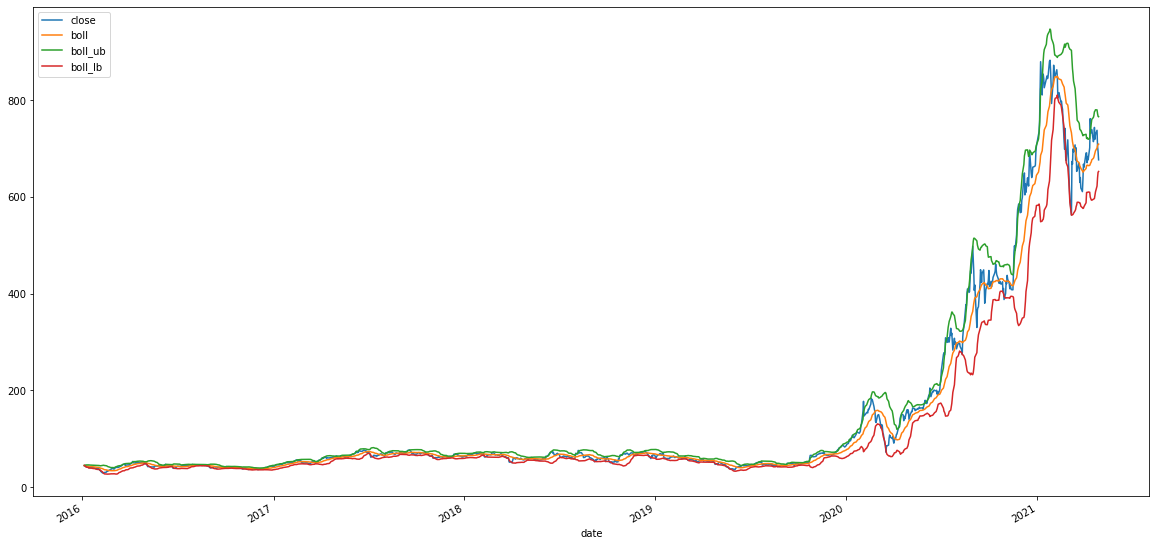

In [38]:
# Plot the Bollinger Bands for BTC/USD closing prices
ETH_BB[['close','boll','boll_ub','boll_lb']].plot(figsize=(20,10))

In [39]:
# Set initial capital
initial_capital = float(10000000)

# Set the share size
share_size = float(1000)

# Take a 1000 share position RSI
ETH_rsi["Trade"] = share_size * ETH_rsi["rsi_signal"] 

# Find the points in time where a 1000 share position is bought or sold
ETH_rsi["Position"] = ETH_rsi["open_position"] * share_size

# Multiply share price by entry/exit positions and get the cumulatively sum
ETH_rsi["Portfolio Holdings"] = ETH_rsi["close"] * ETH_rsi["Position"]

# Subtract the initial capital by the portfolio holdings to get the amount of liquid cash in the portfolio
ETH_rsi["Portfolio Cash"] = (
    initial_capital - (ETH_rsi["Trade"] * ETH_rsi['close']).cumsum()
)

# Get the total portfolio value by adding the cash amount by the portfolio holdings (or investments)
ETH_rsi["Portfolio Total"] = (
    ETH_rsi["Portfolio Cash"] + ETH_rsi["Portfolio Holdings"]
)

# Calculate the portfolio daily returns
ETH_rsi["Portfolio Daily Returns"] = ETH_rsi["Portfolio Total"].pct_change()

# Calculate the cumulative returns
ETH_rsi["Portfolio Cumulative Returns"] = ( 1 + ETH_rsi["Portfolio Daily Returns"]).cumprod() - 1

# Print the DataFrame
ETH_rsi.tail()

open        high         low       close  adj. close  \
date                                                                     
2021-04-23  719.799988  737.359985  715.460022  729.400024  729.400024   
2021-04-26  741.000000  749.299988  732.609985  738.200012  738.200012   
2021-04-27  717.960022  724.000000  703.349976  704.739990  704.739990   
2021-04-28  696.409973  708.500000  693.599976  694.400024  694.400024   
2021-04-29  699.510010  702.250000  668.500000  677.000000  677.000000   

              volume  daily_return  close_-1_s  close_-1_d     rs_14  ...  \
date                                                                  ...   
2021-04-23  28370000      0.013492  719.690002    9.710022  1.214369  ...   
2021-04-26  31038500      0.012065  729.400024    8.799988  1.290028  ...   
2021-04-27  29437000     -0.045326  738.200012  -33.460022  0.984900  ...   
2021-04-28  22271000     -0.014672  704.739990  -10.339966  0.913030  ...   
2021-04-29  28845400     -0.025058  694.400024  -17.400024  0.806392  ...   

            rsi_signal  holding  open_position  Trade  Position  \
date                                                              
2021-04-23         0.0    False            1.0    0.0    1000.0   
2021-04-26         0.0    False            1.0    0.0    1000.0   
2021-04-27         0.0    False            1.0    0.0    1000.0   
2021-04-28         0.0    False            1.0    0.0    1000.0   
2021-04-29         0.0    False            1.0    0.0    1000.0   

            Portfolio Holdings  Portfolio Cash  Portfolio Total  \
date                                                              
2021-04-23       729400.024414    9.510846e+06     1.024025e+07   
2021-04-26       738200.012207    9.510846e+06     1.024905e+07   
2021-04-27       704739.990234    9.510846e+06     1.021559e+07   
2021-04-28       694400.024414    9.510846e+06     1.020525e+07   
2021-04-29       677000.000000    9.510846e+06     1.018785e+07   

            Portfolio Daily Returns  Portfolio Cumulative Returns  
date                                                               
2021-04-23                 0.000949                      0.024025  
2021-04-26                 0.000859                      0.024905  
2021-04-27                -0.003265                      0.021559  
2021-04-28                -0.001012                      0.020525  
2021-04-29                -0.001705                      0.018785  

[5 rows x 21 columns]

In [40]:
# Set initial capital
initial_capital = float(100000)

# Set the share size
share_size = 1000

# Take a 1000 share position RSI
ETH_BB['Trade'] = share_size * ETH_BB["bollinger_signal"] 

# Take a 1000 share position where close < boll lower band
ETH_BB['Position'] = share_size * ETH_BB['open_position']

# Find the points in time where a 1000 share position is bought or sold
#ETH_BB['Entry/Exit Position'] = ETH_BB['Position'].diff()

# Multiply share price by entry/exit positions and get the cumulatively sum
ETH_BB['Portfolio Holdings'] = ETH_BB['close'] * ETH_BB['Position']

# Subtract the initial capital by the portfolio holdings to get the amount of liquid cash in the portfolio
ETH_BB['Portfolio Cash'] = (initial_capital - (ETH_BB['close'] * ETH_BB['Trade']).cumsum())

# Get the total portfolio value by adding the cash amount by the portfolio holdings (or investments)
ETH_BB['Portfolio Total'] = ETH_BB['Portfolio Cash'] + ETH_BB['Portfolio Holdings']

# Calculate the portfolio daily returns
ETH_BB['Portfolio Daily Returns'] = ETH_BB['Portfolio Total'].pct_change()

# Calculate the cumulative returns
ETH_BB['Portfolio Cumulative Returns'] = (1 + ETH_BB['Portfolio Daily Returns']).cumprod() - 1

# Print the DataFrame
ETH_BB.tail()

close        boll     boll_ub     boll_lb  bollinger_signal  \
date                                                                           
2021-04-23  729.400024  695.587497  780.563757  610.611237               0.0   
2021-04-26  738.200012  701.561996  780.357361  622.766632               0.0   
2021-04-27  704.739990  706.234497  772.592040  639.876954               0.0   
2021-04-28  694.400024  709.173499  767.023903  651.323094               0.0   
2021-04-29  677.000000  709.626999  766.245153  653.008844               0.0   

            open_position  Trade  Position  Portfolio Holdings  \
date                                                             
2021-04-23            0.0    0.0       0.0                 0.0   
2021-04-26            0.0    0.0       0.0                 0.0   
2021-04-27            0.0    0.0       0.0                 0.0   
2021-04-28            0.0    0.0       0.0                 0.0   
2021-04-29            0.0    0.0       0.0                 0.0   

            Portfolio Cash  Portfolio Total  Portfolio Daily Returns  \
date                                                                   
2021-04-23   297406.017303    297406.017303                      0.0   
2021-04-26   297406.017303    297406.017303                      0.0   
2021-04-27   297406.017303    297406.017303                      0.0   
2021-04-28   297406.017303    297406.017303                      0.0   
2021-04-29   297406.017303    297406.017303                      0.0   

            Portfolio Cumulative Returns  
date                                      
2021-04-23                       1.97406  
2021-04-26                       1.97406  
2021-04-27                       1.97406  
2021-04-28                       1.97406  
2021-04-29                       1.97406

In [41]:
ETH_BB.dropna(inplace = True)

In [42]:
# Visualize exit position relative to close price
exit = ETH_BB[ETH_BB['bollinger_signal'] == -1.0]['close'].hvplot.scatter(
    color='red',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize entry position relative to close price
entry = ETH_BB[ETH_BB['bollinger_signal'] == 1.0]['close'].hvplot.scatter(
    color='green',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize close price for the investment
security_close = ETH_BB[['close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize moving averages
bollinger_bands = ETH_BB[['boll','boll_ub', 'boll_lb']].hvplot(
    ylabel='Price in $',
    width=1000,
    height=400
)

# Overlay plots
entry_exit_plot = security_close * bollinger_bands * entry * exit
entry_exit_plot.opts(xaxis=None)

:Overlay
   .Curve.I          :Curve   [date]   (close)
   .NdOverlay.I      :NdOverlay   [Variable]
      :Curve   [date]   (value)
   .Scatter.Close.I  :Scatter   [date]   (close)
   .Scatter.Close.II :Scatter   [date]   (close)

In [43]:
frame = [ETH_rsi, ETH_sma, ETH_BB]
ETH_data_df = pd.concat(
    frame,
    axis = 1,
    join="inner",
    ignore_index=False,
    keys=None,
    levels=None,
    names=None,
    verify_integrity=False,
    copy=True,
   
)


ETH_data_df.head()

open       high        low      close  adj. close    volume  \
date                                                                           
2016-01-06  44.000000  44.009998  43.195999  43.807999   43.807999  18895500   
2016-01-07  42.838001  43.688000  42.734001  43.130001   43.130001  17771500   
2016-01-08  43.571999  44.088001  42.153999  42.200001   42.200001  18140500   
2016-01-11  42.801998  42.889999  40.599998  41.570000   41.570000  20457000   
2016-01-12  42.320000  42.748001  41.062000  41.993999   41.993999  15459500   

            daily_return  close_-1_s  close_-1_d     rs_14  ...    boll_lb  \
date                                                        ...              
2016-01-06     -0.019648   44.686001   -0.878002  0.004232  ...  43.380472   
2016-01-07     -0.015477   43.807999   -0.677998  0.002311  ...  42.568268   
2016-01-08     -0.021563   43.130001   -0.930000  0.001383  ...  41.574448   
2016-01-11     -0.014929   42.200001   -0.630001  0.001070  ...  40.767925   
2016-01-12      0.010200   41.570000    0.424000  0.165252  ...  40.587074   

            bollinger_signal  open_position  Trade  Position  \
date                                                           
2016-01-06               0.0            0.0    0.0       0.0   
2016-01-07               0.0            0.0    0.0       0.0   
2016-01-08               0.0            0.0    0.0       0.0   
2016-01-11               0.0            0.0    0.0       0.0   
2016-01-12               0.0            0.0    0.0       0.0   

            Portfolio Holdings  Portfolio Cash  Portfolio Total  \
date                                                              
2016-01-06                 0.0        100000.0         100000.0   
2016-01-07                 0.0        100000.0         100000.0   
2016-01-08                 0.0        100000.0         100000.0   
2016-01-11                 0.0        100000.0         100000.0   
2016-01-12                 0.0        100000.0         100000.0   

            Portfolio Daily Returns  Portfolio Cumulative Returns  
date                                                               
2016-01-06                      0.0                           0.0  
2016-01-07                      0.0                           0.0  
2016-01-08                      0.0                           0.0  
2016-01-11                      0.0                           0.0  
2016-01-12                      0.0                           0.0  

[5 rows x 46 columns]

In [44]:
# build ETH trading signals df 
ETH_signals = ETH_data_df[['rsi_signal', 'sma_signal', 'bollinger_signal', 'daily_return']]
ETH_signals = ETH_signals
ETH_signals.head()

rsi_signal  sma_signal  bollinger_signal  daily_return
date                                                              
2016-01-06         1.0         0.0               0.0     -0.019648
2016-01-07         0.0         0.0               0.0     -0.015477
2016-01-08         0.0         0.0               0.0     -0.021563
2016-01-11         0.0         0.0               0.0     -0.014929
2016-01-12         0.0         0.0               0.0      0.010200

In [45]:
# Set x variable list of features and Shift DataFrame values by 1
ETH_x_var_list = ['rsi_signal', 'sma_signal', 'bollinger_signal']
ETH_signals[ETH_x_var_list ] = ETH_signals[ETH_x_var_list].shift(1)
ETH_signals.dropna(inplace = True)
ETH_signals[ETH_x_var_list].tail


<bound method NDFrame.tail of             rsi_signal  sma_signal  bollinger_signal
date                                                
2016-01-07         1.0         0.0               0.0
2016-01-08         0.0         0.0               0.0
2016-01-11         0.0         0.0               0.0
2016-01-12         0.0         0.0               0.0
2016-01-13         0.0         0.0               0.0
...                ...         ...               ...
2021-04-23         0.0         0.0               0.0
2021-04-26         0.0         0.0               0.0
2021-04-27         0.0         0.0               0.0
2021-04-28         0.0         0.0               0.0
2021-04-29         0.0         0.0               0.0

[1337 rows x 3 columns]>

In [46]:
# get ETH result df, use daily return to determine actual value
ETH_results = ETH_signals[['daily_return']]
ETH_results['actual_value'] = np.where(ETH_signals['daily_return'] > 0, 1.0, 0.0)
ETH_results.head()

daily_return  actual_value
date                                  
2016-01-07     -0.015477           0.0
2016-01-08     -0.021563           0.0
2016-01-11     -0.014929           0.0
2016-01-12      0.010200           1.0
2016-01-13     -0.046007           0.0

In [47]:
# Construct training start and end dates
ETH_training_start = ETH_signals.index.min().strftime(format= '%Y-%m-%d')
ETH_training_end = '2019-12-31'

# Construct testing start and end dates
ETH_testing_start =  '2020-01-01'
ETH_testing_end = ETH_signals.index.max().strftime(format= '%Y-%m-%d')

# Print training and testing start/end dates
print(f"ETH Training Start: {ETH_training_start}")
print(f"ETH Training End: {ETH_training_end}")
print(f"ETH Testing Start: {ETH_testing_start}")
print(f"ETH Testing End: {ETH_testing_end}")

ETH Training Start: 2016-01-07
ETH Training End: 2019-12-31
ETH Testing Start: 2020-01-01
ETH Testing End: 2021-04-29


In [48]:
# Construct the X_train and y_train datasets
ETH_X_train = ETH_signals[ETH_x_var_list][ETH_training_start:ETH_training_end]
ETH_y_train = ETH_results['actual_value'][ETH_training_start:ETH_training_end]


In [49]:
# Construct the X test and y test datasets
ETH_X_test = ETH_signals[ETH_x_var_list][ETH_testing_start:ETH_testing_end]
ETH_y_test = ETH_results['actual_value'][ETH_testing_start:ETH_testing_end]

ETH_X_test.tail()

rsi_signal  sma_signal  bollinger_signal
date                                                
2021-04-23         0.0         0.0               0.0
2021-04-26         0.0         0.0               0.0
2021-04-27         0.0         0.0               0.0
2021-04-28         0.0         0.0               0.0
2021-04-29         0.0         0.0               0.0

In [50]:
# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
ETH_forest_model = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0)
ETH_forest_model.fit(ETH_X_train, ETH_y_train)

# Make a prediction of "y" values from the X_test dataset
ETH_predictions = ETH_forest_model.predict(ETH_X_test)

# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
ETH_Model_Results = ETH_y_test.to_frame()
ETH_Model_Results["Predicted Value"] = ETH_predictions
ETH_Model_Results["daily_return"] = ETH_signals[['daily_return']]
ETH_Model_Results.head()

actual_value  Predicted Value  daily_return
date                                                   
2020-01-02           1.0              1.0      0.028518
2020-01-03           1.0              1.0      0.029633
2020-01-06           1.0              1.0      0.019255
2020-01-07           1.0              1.0      0.038801
2020-01-08           1.0              1.0      0.049205

<AxesSubplot:xlabel='date'>

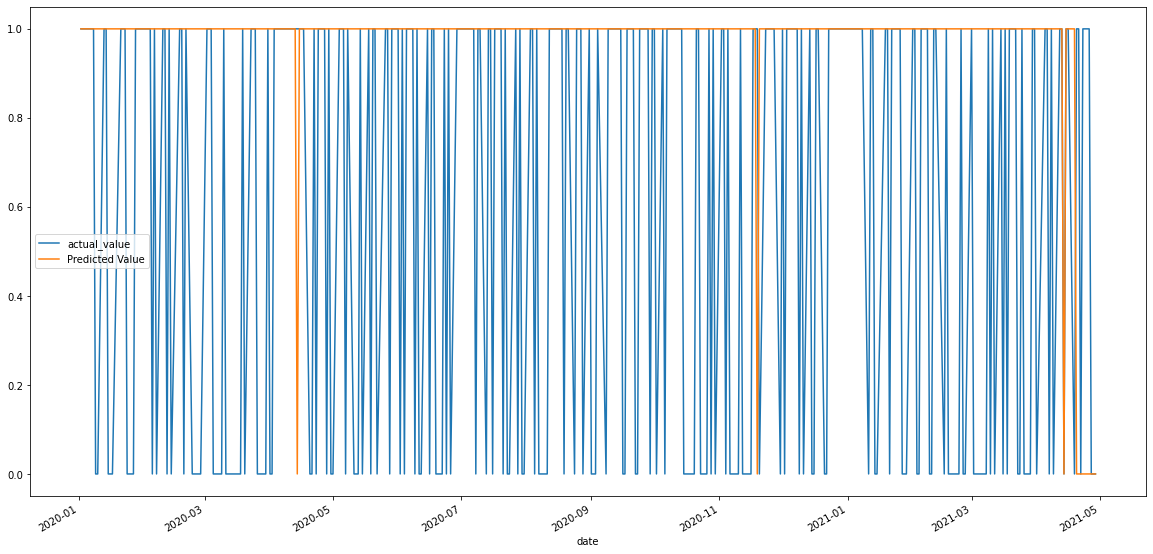

In [51]:
# Plot predicted results vs. actual results
ETH_Model_Results[['actual_value', 'Predicted Value']].plot(figsize=(20,10))

<AxesSubplot:xlabel='date'>

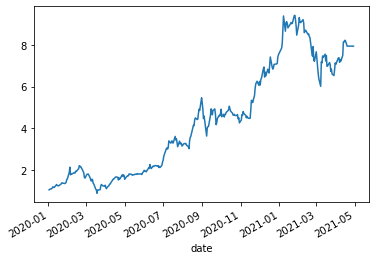

In [52]:
# Calculate cumulative return of model and plot the result

(1 + (ETH_Model_Results['daily_return'] * ETH_Model_Results['Predicted Value'])).cumprod().plot()

<AxesSubplot:xlabel='date'>

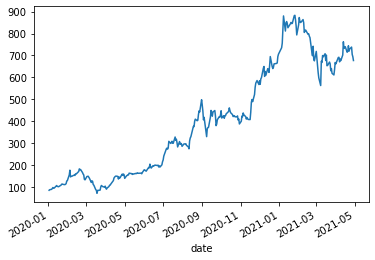

In [53]:
df_ETH_data['close'][ETH_testing_start:ETH_testing_end].plot()

In [54]:
ETH_data_df['Predicted Value'] = 0
ETH_data_df['Predicted Value'][ETH_testing_start:ETH_testing_end] = ETH_predictions
ETH_data_df['real_close'] = ETH_data_df.iloc[:,3]

ETH_data_df.tail()

open        high         low       close  adj. close  \
date                                                                     
2021-04-23  719.799988  737.359985  715.460022  729.400024  729.400024   
2021-04-26  741.000000  749.299988  732.609985  738.200012  738.200012   
2021-04-27  717.960022  724.000000  703.349976  704.739990  704.739990   
2021-04-28  696.409973  708.500000  693.599976  694.400024  694.400024   
2021-04-29  699.510010  702.250000  668.500000  677.000000  677.000000   

              volume  daily_return  close_-1_s  close_-1_d     rs_14  ...  \
date                                                                  ...   
2021-04-23  28370000      0.013492  719.690002    9.710022  1.214369  ...   
2021-04-26  31038500      0.012065  729.400024    8.799988  1.290028  ...   
2021-04-27  29437000     -0.045326  738.200012  -33.460022  0.984900  ...   
2021-04-28  22271000     -0.014672  704.739990  -10.339966  0.913030  ...   
2021-04-29  28845400     -0.025058  694.400024  -17.400024  0.806392  ...   

            open_position  Trade  Position  Portfolio Holdings  \
date                                                             
2021-04-23            0.0    0.0       0.0                 0.0   
2021-04-26            0.0    0.0       0.0                 0.0   
2021-04-27            0.0    0.0       0.0                 0.0   
2021-04-28            0.0    0.0       0.0                 0.0   
2021-04-29            0.0    0.0       0.0                 0.0   

            Portfolio Cash  Portfolio Total  Portfolio Daily Returns  \
date                                                                   
2021-04-23   297406.017303    297406.017303                      0.0   
2021-04-26   297406.017303    297406.017303                      0.0   
2021-04-27   297406.017303    297406.017303                      0.0   
2021-04-28   297406.017303    297406.017303                      0.0   
2021-04-29   297406.017303    297406.017303                      0.0   

            Portfolio Cumulative Returns  Predicted Value  real_close  
date                                                                   
2021-04-23                       1.97406                0  729.400024  
2021-04-26                       1.97406                0  738.200012  
2021-04-27                       1.97406                0  704.739990  
2021-04-28                       1.97406                0  694.400024  
2021-04-29                       1.97406                0  677.000000  

[5 rows x 48 columns]

In [55]:
# Set initial capital allocation
initial_capital = 100000

# Plot cumulative return of model in terms of capital
ETH_cumulative_return_capital = initial_capital * (1 + (ETH_Model_Results['daily_return'] * ETH_Model_Results['Predicted Value'])).cumprod()
ETH_cumulative_return_capital

date
2020-01-02    102851.817437
2020-01-03    105899.645002
2020-01-06    107938.706598
2020-01-07    112126.785133
2020-01-08    117643.966453
                  ...      
2021-04-23    794787.440901
2021-04-26    794787.440901
2021-04-27    794787.440901
2021-04-28    794787.440901
2021-04-29    794787.440901
Length: 334, dtype: float64

## Naive Bayes Classification trading

In [56]:
# import liabiary
from sklearn.naive_bayes import GaussianNB

In [57]:
# Construct the X_train, y_train, X_test, y_test datasets
ETH_nb_train_X = ETH_signals[ETH_x_var_list][ETH_training_start:ETH_training_end]
ETH_nb_train_y = ETH_results['actual_value'][ETH_training_start:ETH_training_end]
ETH_nb_test_X = ETH_signals[ETH_x_var_list][ETH_testing_start:ETH_testing_end]
ETH_nb_test_y = ETH_results['actual_value'][ETH_testing_start:ETH_testing_end]
# fit NB model with training dataset
ETH_nb_model = GaussianNB()
ETH_nb_model.fit(ETH_nb_train_X, ETH_nb_train_y)

GaussianNB()

In [58]:
# Add predicted results to DataFrame
ETH_nb_results = pd.DataFrame()

ETH_nb_results[ETH_x_var_list] = ETH_X_test[ETH_x_var_list]
ETH_nb_results['actual_value'] = ETH_results['actual_value']
ETH_nb_results['prediction'] = ETH_nb_model.predict(ETH_nb_test_X)
ETH_nb_results['daily_return'] = ETH_signals[['daily_return']]
ETH_nb_results.head()

rsi_signal  sma_signal  bollinger_signal  actual_value  \
date                                                                 
2020-01-02         0.0         1.0               0.0           1.0   
2020-01-03         0.0         1.0               0.0           1.0   
2020-01-06         0.0         1.0               0.0           1.0   
2020-01-07         0.0         1.0               0.0           1.0   
2020-01-08         0.0         1.0               0.0           1.0   

            prediction  daily_return  
date                                  
2020-01-02         0.0      0.028518  
2020-01-03         0.0      0.029633  
2020-01-06         0.0      0.019255  
2020-01-07         0.0      0.038801  
2020-01-08         0.0      0.049205

<AxesSubplot:xlabel='date'>

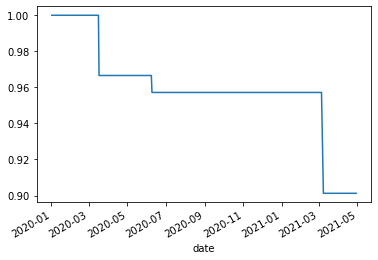

In [59]:
# Calculate cumulative return of model and plot the result
(1 + (ETH_nb_results['daily_return'] * ETH_nb_results['prediction'])).cumprod().plot()